# Imports

In [1]:
import os
import sys
from collections import defaultdict
import networkx as nx
from node2vec import Node2Vec
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, f1_score, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import resample


In [2]:
# Get the absolute path to the parent directory containing the mj module
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, parent_directory)

# Import mj as a module first
import mj
from mj import utils
import importlib

# Then reload both the package and the module
importlib.reload(mj)
importlib.reload(mj.utils)
importlib.reload(utils)

# Now you can import from mj.utils
from mj.utils import NODE2VEC_SEED


In [3]:
from mj import utils

### Functions

In [4]:
def load_graphs(m):
    gr = []
    for month in m:
        with open(f'../../data/graphs/{month}.pkl', 'rb') as f:
            g = pickle.load(f)
            gr.append(g)
    return gr

In [5]:
def create_nv_models(graphs, w_length, n_walks, dim=64):
    if len(graphs) != 4:
        raise ValueError('There must be exactly 4 graphs')
    j_nv = Node2Vec(graphs[0], dimensions=dim, walk_length=w_length, num_walks=n_walks, seed=NODE2VEC_SEED)
    j_model = j_nv.fit(window=10, min_count=1, batch_words=4)
    f_nv = Node2Vec(graphs[1], dimensions=dim, walk_length=w_length, num_walks=n_walks, seed=NODE2VEC_SEED)
    f_model = f_nv.fit(window=10, min_count=1, batch_words=4)
    m_nv = Node2Vec(graphs[2], dimensions=dim, walk_length=w_length, num_walks=n_walks, seed=NODE2VEC_SEED)
    m_model = m_nv.fit(window=10, min_count=1, batch_words=4)
    a_nv = Node2Vec(graphs[3], dimensions=dim, walk_length=w_length, num_walks=n_walks, seed=NODE2VEC_SEED)
    a_model = a_nv.fit(window=10, min_count=1, batch_words=4)
    return j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model

In [6]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Experiment 1: Dot products

In [ ]:
months = ['israel_palestine_train_graph_2023-07-31', 'israel_palestine_train_graph_2023-08-31', 'israel_palestine_train_graph_2023-09-30', 'israel_palestine_train_graph_2023-10-31']
graphs = load_graphs(months)

In [58]:
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 30, 100)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 35.30it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 37.77it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


In [59]:
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector

In [60]:
len(j_model.wv['USA'])

64

### Scalar product of two vectors for link prediction

In [61]:
dot_products = dict()
for node1 in avg_vectors:
    for node2 in avg_vectors:
        if node1 != node2:
            vector1 = np.array(avg_vectors[node1])
            vector2 = np.array(avg_vectors[node2])
            n_sorted = sorted([node1, node2])
            dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = np.dot(vector1, vector2)

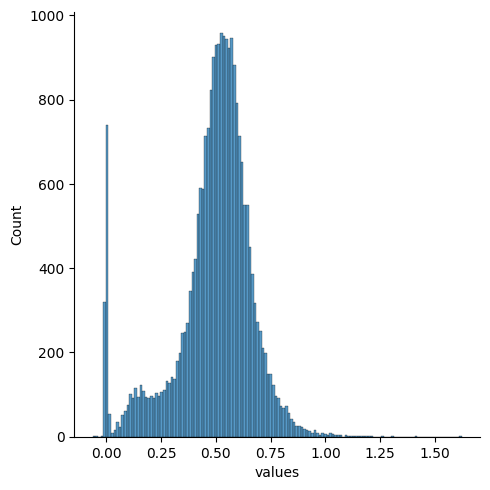

In [62]:
sns.displot(pd.DataFrame({'values':dot_products.values()}), x='values')

In [66]:
with open(f'../../data/graphs/israel_palestine_test_graph_2023-11-30.pkl', 'rb') as f: 
        target_graph = pickle.load(f)

In [67]:
nodes = target_graph.nodes
ds_dict = dict() # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])            
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, dot_products[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])            
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, dot_products[f'{n_sorted[0]}-{n_sorted[1]}'])

In [68]:
num_t = len([el for el in ds_dict.values() if el[0] == 1])
num_f = len([el for el in ds_dict.values() if el[0] == 0])
print(num_t, num_f)

1564 22967


##### The dataset is not balanced, and therefore, we must use downsampling, so that our trained model can be more accurate

In [69]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]  
minority_class = data[data['y'] == 1]  

majority_undersampled = resample(majority_class, 
                                 replace=False,  
                                 n_samples=len(minority_class),  
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.3, random_state=42)

In [70]:
len(X_train) == len(y_train)

True

In [71]:
model = LogisticRegression()
model.fit(X_train.reshape(-1,1), y_train)
predictions = model.predict(X_test.reshape(-1,1))
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

Accuracy 0.5463258785942492
Recall 0.5856832971800434
F1-score 0.5590062111801242
Classification metrics:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       478
           1       0.53      0.59      0.56       461

    accuracy                           0.55       939
   macro avg       0.55      0.55      0.55       939
weighted avg       0.55      0.55      0.55       939



### Testing exp 1 function

In [73]:
graph_model_data = utils.create_train_test_objects('israel_palestine', num_walks=30, walk_length=100, dimensions=64)

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


In [74]:
graph_model_data.keys()

dict_keys(['2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31'])

In [75]:
target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])

In [76]:
len(target_graphs[1].edges)

1880

In [ ]:
nv_models = []
# Extract models from the first 4 months in graph_model_data
keys = list(graph_model_data.keys())[:4]
nv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)

keys = list(graph_model_data.keys())[5:9]
nv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)

In [78]:
nv_models

[[<gensim.models.word2vec.Word2Vec at 0x27fdab074c0>,

In [79]:
utils.summary_evaluation_for_month_groups_ex_1(
    model=model,
    target_graphs=target_graphs,
    nv_models=nv_models
)

Majority class size: 22967,
Minority class size: 1564
Majority class size: 23141,
Minority class size: 1390


{'mean_acc': 0.5924189037516789,
 'mean_prec': 0.5675479294206256,
 'mean_rec': 0.7810783087085319,
 'mean_f1': 0.6558489809869923,
 'all_metrics': [[0.5895140664961637, 0.5953237410071942],
  [0.5720906282183316, 0.5630052306229196],
  [0.7103580562659847, 0.8517985611510791],
  [0.6337706788362807, 0.677927283137704]]}

### Test with other months

In [25]:
months = ['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 30, 100)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 35.23it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 35.89it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 36.36it/s]


In [63]:
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector

In [64]:
dot_products = dict()
for node1 in avg_vectors:
    for node2 in avg_vectors:
        if node1 != node2:
            vector1 = np.array(avg_vectors[node1])
            vector2 = np.array(avg_vectors[node2])
            n_sorted = sorted([node1, node2])
            dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = np.dot(vector1, vector2)

In [65]:
with open(f'../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, dot_products[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, dot_products[f'{n_sorted[0]}-{n_sorted[1]}'])

In [68]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]  
minority_class = data[data['y'] == 1]  

majority_undersampled = resample(majority_class, 
                                 replace=False,  
                                 n_samples=len(minority_class),  
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'])
balanced_y = np.array(balanced_data['y'])

In [70]:
predictions = model.predict(balanced_X.reshape(-1,1))
print('Accuracy', accuracy_score(balanced_y, predictions))
print('Recall', recall_score(balanced_y, predictions))
print('F1-score', f1_score(balanced_y, predictions))
print("Classification metrics:")
print(classification_report(balanced_y, predictions))

Accuracy 0.5928111587982833
Recall 0.5198497854077253
F1-score 0.5607638888888888
Classification metrics:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1864
           1       0.61      0.52      0.56      1864

    accuracy                           0.59      3728
   macro avg       0.59      0.59      0.59      3728
weighted avg       0.59      0.59      0.59      3728



##### Conclusion for the first experiment: the classification metrics are significantly worse for other sequences of months (~-10)

# Experiment 2: Lowering random walks and walks length numbers and using the number of occurrences of other countries in the random walks as a scaling factor of the dot product between two countries and then use the mean of the scaled dot products of the four sequential months

In [7]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 714.29it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 312.49it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 208.32it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 238.10it/s]


In [8]:
nodes = graphs[0].nodes
nodes_enc = {node: idx for idx, node in enumerate(nodes)}

In [9]:
counts = utils.count_occurences(n_vecs, nodes, nodes_enc)

In [10]:
averaged_counts = utils.average_counts(counts, nodes_enc)
for node in nodes_enc:
    month_lists = [month[nodes_enc[node]] for month in counts.values()]
    averaged_counts[node] = np.mean(month_lists, axis=0)

In [11]:
dot_products_per_month_weighted = dict()
for i, model in enumerate(nv_models):
    vectors = dict()
    for node in nodes:
        vectors[node] = model.wv[node]
    dot_products = dict()
    for node1 in vectors:
        for node2 in vectors:
            if node1 != node2:
                vector1 = np.array(vectors[node1])
                vector2 = np.array(vectors[node2])
                n_sorted = sorted([node1, node2])
                dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = (np.dot(vector1, vector2) * max(counts[i][nodes_enc[n_sorted[0]]][nodes_enc[n_sorted[1]]], counts[i][nodes_enc[n_sorted[1]]][nodes_enc[n_sorted[0]]])
                                                                        )
    dot_products_per_month_weighted[i] = dot_products

In [12]:
predictions = dict()
for pair in dot_products_per_month_weighted[0]:
    prediction = 0
    for month in range(len(nv_models)):
        prediction += dot_products_per_month_weighted[month][pair]
    predictions[pair] = (prediction / len(nv_models))

In [13]:
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
        target_graph = pickle.load(f) # fifth month graph

In [14]:
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
num_t = len([el for el in ds_dict.values() if el[0] == 1])
num_f = len([el for el in ds_dict.values() if el[0] == 0])
print(num_t, num_f)

1864 22667


In [18]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.3, random_state=42)
model_lr = LogisticRegression()
model_lr.fit(X_train.reshape(-1, 1), y_train)
predictions = model_lr.predict(X_test.reshape(-1, 1))
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

Accuracy 0.7533512064343163
Recall 0.6954887218045113
F1-score 0.7283464566929134
Classification metrics:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       587
           1       0.76      0.70      0.73       532

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119



In [15]:
graph_model_data = utils.create_train_test_objects(prefix='israel_palestine', num_walks=5, walk_length=5, dimensions=64)

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


In [16]:
target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])
len(target_graphs[1].edges)
nv_models = []
wv_models = []
# Extract models from the first 4 months in graph_model_data
keys = list(graph_model_data.keys())[:4]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
    
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)

keys = list(graph_model_data.keys())[5:9]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)
nv_models, wv_models



([[<node2vec.node2vec.Node2Vec at 0x1f3b5724880>,
 [[<gensim.models.word2vec.Word2Vec at 0x1f3b5bf2740>,
   <gensim.models.word2vec.Word2Vec at 0x1f3b75bf4f0>]])

### function test

In [27]:
utils.summary_evaluation_for_month_groups_ex_2(
    model = model_lr,
    target_graphs = target_graphs,
    wv_models = wv_models,
    n_vecs = nv_models
)

i= 0


KeyError: 1

In [36]:
results = utils.summary_evaluation_for_month_groups_ex_2(
    model = model_lr,
    target_graphs = target_graphs,
    wv_models = wv_models,
    n_vecs = nv_models
)
results

Majority class size: 22967,
Minority class size: 1564
Majority class size: 23141,
Minority class size: 1390


{'mean_acc': 0.6166371506375463,
 'mean_prec': 0.7643177058616595,
 'mean_rec': 0.33766168650757145,
 'mean_f1': 0.4680997003431572,
 'all_metrics': [[0.6192455242966752, 0.6140287769784173],
  [0.7558299039780522, 0.7728055077452668],
  [0.3523017902813299, 0.32302158273381293],
  [0.4805931094635848, 0.45560629122272955]]}

### Test1 with other months

In [233]:
months = ['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 45.31it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 22.71it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 63.36it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 80.49it/s]


In [234]:
counts = count_occurences(n_vecs, nodes, nodes_enc)
averaged_counts = average_counts(counts, nodes_enc)
for node in nodes_enc:
    month_lists = [month[nodes_enc[node]] for month in counts.values()]
    averaged_counts[node] = np.mean(month_lists, axis=0)
dot_products_per_month_weighted = dict()
for i, model in enumerate(nv_models):
    vectors = dict()
    for node in nodes:
        vectors[node] = model.wv[node]
    dot_products = dict()
    for node1 in vectors:
        for node2 in vectors:
            if node1 != node2:
                vector1 = np.array(vectors[node1])
                vector2 = np.array(vectors[node2])
                n_sorted = sorted([node1, node2])
                dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = (
                            np.dot(vector1, vector2) * max(counts[i][nodes_enc[n_sorted[0]]][nodes_enc[n_sorted[1]]],
                                                           counts[i][nodes_enc[n_sorted[1]]][nodes_enc[n_sorted[0]]])
                            )
    dot_products_per_month_weighted[i] = dot_products
predictions = dict()
for pair in dot_products_per_month_weighted[0]:
    prediction = 0
    for month in range(len(nv_models)):
        prediction += dot_products_per_month_weighted[month][pair]
    predictions[pair] = (prediction / len(nv_models))
with open(f'../data/graphs/graph_2018-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)  # fifth month graph
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])

In [235]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])

predictions = model_lr.predict(balanced_X.reshape(-1, 1))
print('Accuracy', accuracy_score(balanced_y, predictions))
print('Recall', recall_score(balanced_y, predictions))
print('F1-score', f1_score(balanced_y, predictions))
print("Classification metrics:")
print(classification_report(balanced_y, predictions))

Accuracy 0.7359773371104816
Recall 0.771671388101983
F1-score 0.7450765864332604
Classification metrics:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      1765
           1       0.72      0.77      0.75      1765

    accuracy                           0.74      3530
   macro avg       0.74      0.74      0.74      3530
weighted avg       0.74      0.74      0.74      3530



### Test2

In [ ]:
months = ['2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
counts = count_occurences(n_vecs, nodes, nodes_enc)
averaged_counts = average_counts(counts, nodes_enc)
for node in nodes_enc:
    month_lists = [month[nodes_enc[node]] for month in counts.values()]
    averaged_counts[node] = np.mean(month_lists, axis=0)
dot_products_per_month_weighted = dict()
for i, model in enumerate(nv_models):
    vectors = dict()
    for node in nodes:
        vectors[node] = model.wv[node]
    dot_products = dict()
    for node1 in vectors:
        for node2 in vectors:
            if node1 != node2:
                vector1 = np.array(vectors[node1])
                vector2 = np.array(vectors[node2])
                n_sorted = sorted([node1, node2])
                dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = (
                        np.dot(vector1, vector2) * max(counts[i][nodes_enc[n_sorted[0]]][nodes_enc[n_sorted[1]]],
                                                       counts[i][nodes_enc[n_sorted[1]]][nodes_enc[n_sorted[0]]])
                )
    dot_products_per_month_weighted[i] = dot_products
predictions = dict()
for pair in dot_products_per_month_weighted[0]:
    prediction = 0
    for month in range(len(nv_models)):
        prediction += dot_products_per_month_weighted[month][pair]
    predictions[pair] = (prediction / len(nv_models))
with open(f'../data/graphs/graph_2015-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)  # fifth month graph
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])

predictions = model_lr.predict(balanced_X.reshape(-1, 1))
print('Accuracy', accuracy_score(balanced_y, predictions))
print('Recall', recall_score(balanced_y, predictions))
print('F1-score', f1_score(balanced_y, predictions))
print("Classification metrics:")
print(classification_report(balanced_y, predictions))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 62.50it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 27.32it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Accuracy 0.731700288184438
Recall 0.7798270893371758
F1-score 0.7440197965356062
Classification metrics:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1735
           1       0.71      0.78      0.74      1735

    accuracy                           0.73      3470
   macro avg       0.73      0.73      0.73      3470
weighted avg       0.73      0.73      0.73      3470



##### Conclusion for the second experiment: This approach works very well, and all the metrics are not chaning 

# Experiment 3: Multiply each node2vec vector by the occurrence rate of the other country in the random walks and then calculate dot product


In [7]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 754.07it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 338.99it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 100.60it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 221.39it/s]


In [8]:
nodes = graphs[0].nodes
nodes_enc = {node: idx for idx, node in enumerate(nodes)}
counts = utils.count_occurences(n_vecs, nodes, nodes_enc)
averaged_counts = utils.average_counts(counts, nodes_enc)
for node in nodes_enc:
    month_lists = [month[nodes_enc[node]] for month in counts.values()]
    averaged_counts[node] = np.mean(month_lists, axis=0)

In [9]:
dot_products_per_month_weighted = dict()
for i, model in enumerate(nv_models):
    vectors = dict()
    for node in nodes:
        vectors[node] = model.wv[node]
    dot_products = dict()
    for node1 in vectors:
        for node2 in vectors:
            if node1 != node2:
                n_sorted = sorted([node1, node2])
                vector1 = np.array(vectors[node1]) * counts[i][nodes_enc[n_sorted[0]]][nodes_enc[n_sorted[1]]]
                vector2 = np.array(vectors[node2]) * counts[i][nodes_enc[n_sorted[1]]][nodes_enc[n_sorted[0]]]
                dot_products[f'{n_sorted[0]}-{n_sorted[1]}'] = (np.dot(vector1, vector2))
    dot_products_per_month_weighted[i] = dot_products

In [10]:
predictions = dict()
for pair in dot_products_per_month_weighted[0]:
    prediction = 0
    for month in range(len(nv_models)):
        prediction += dot_products_per_month_weighted[month][pair]
    predictions[pair] = (prediction / len(nv_models))

In [11]:
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)  # fifth month graph
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, predictions[f'{n_sorted[0]}-{n_sorted[1]}'])
num_t = len([el for el in ds_dict.values() if el[0] == 1])
num_f = len([el for el in ds_dict.values() if el[0] == 0])
print(num_t, num_f)

1864 22667


In [12]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.3, random_state=42)
model_lr = LogisticRegression()
model_lr.fit(X_train.reshape(-1, 1), y_train)
predictions = model_lr.predict(X_test.reshape(-1, 1))
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

Accuracy 0.47542448614834676
Recall 1.0
F1-score 0.6444579043004239
Classification metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       587
           1       0.48      1.00      0.64       532

    accuracy                           0.48      1119
   macro avg       0.24      0.50      0.32      1119
weighted avg       0.23      0.48      0.31      1119



z:\Users\onira\Documents\_FINKI\VNP PROJECT\xai-graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\Users\onira\Documents\_FINKI\VNP PROJECT\xai-graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\Users\onira\Documents\_FINKI\VNP PROJECT\xai-graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

##### Conclusion for the third experiment: The results are not satisfactory. This approach is very limiting, since we multiply each value of the vector by some scaling factor, which can many times be zero

In [13]:
graph_model_data = utils.create_train_test_objects(
    prefix='israel_palestine',
    num_walks=5,
    walk_length=5,
    dimensions=64
)
target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])
len(target_graphs[1].edges)
nv_models = []
wv_models = []
# Extract models from the first 4 months in graph_model_data
keys = list(graph_model_data.keys())[:4]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)
keys = list(graph_model_data.keys())[5:9]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)
nv_models, wv_models

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


([[<node2vec.node2vec.Node2Vec at 0x241e2403790>,
 [[<gensim.models.word2vec.Word2Vec at 0x241eb5160b0>,
   <gensim.models.word2vec.Word2Vec at 0x241ed853d30>]])

In [14]:
utils.summary_evaluation_for_month_groups_ex_2(
    model=model_lr,
    target_graphs=target_graphs,
    wv_models=wv_models,
    n_vecs=nv_models
)

Majority class size: 22967,
Minority class size: 1564
Majority class size: 23141,
Minority class size: 1390


{'mean_acc': 0.5,
 'mean_prec': 0.5,
 'mean_rec': 1.0,
 'mean_f1': 0.6666666666666666,
 'all_metrics': [[0.5, 0.5],
  [0.5, 0.5],
  [1.0, 1.0],
  [0.6666666666666666, 0.6666666666666666]]}

# Experiment 4: Cosine similarity of the averaged vectors for 4 months

In [47]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 689.70it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 325.66it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 240.58it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 245.22it/s]


In [10]:
cos_similarities = dict()
for node1 in avg_vectors:
    for node2 in avg_vectors:
        if node1 != node2:
            vector1 = np.array(avg_vectors[node1])
            vector2 = np.array(avg_vectors[node2])
            n_sorted = sorted([node1, node2])
            cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'] = cosine_similarity(vector1, vector2)

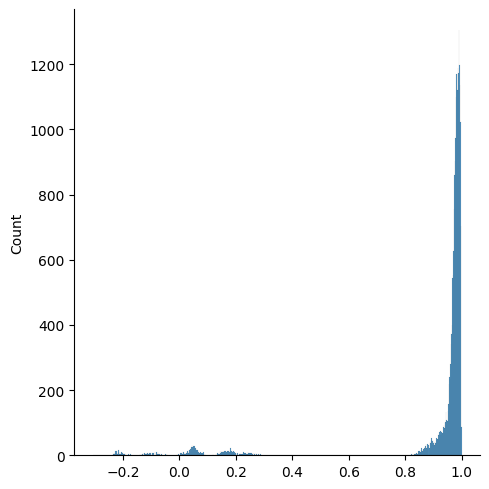

In [11]:
sns.displot(list(cos_similarities.values()))

In [12]:
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'])
num_t = len([el for el in ds_dict.values() if el[0] == 1])
num_f = len([el for el in ds_dict.values() if el[0] == 0])
print(num_t, num_f)

1864 22667


In [13]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.3, random_state=42)
model_lr = LogisticRegression()
model_lr.fit(X_train.reshape(-1, 1), y_train)
predictions = model_lr.predict(X_test.reshape(-1, 1))
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

Accuracy 0.5576407506702413
Recall 0.9454887218045113
F1-score 0.670219853431046
Classification metrics:
              precision    recall  f1-score   support

           0       0.81      0.21      0.33       587
           1       0.52      0.95      0.67       532

    accuracy                           0.56      1119
   macro avg       0.66      0.58      0.50      1119
weighted avg       0.67      0.56      0.49      1119



### Test with other months

In [ ]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector
cos_similarities = dict()
for node1 in avg_vectors:
    for node2 in avg_vectors:
        if node1 != node2:
            vector1 = np.array(avg_vectors[node1])
            vector2 = np.array(avg_vectors[node2])
            n_sorted = sorted([node1, node2])
            cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'] = cosine_similarity(vector1, vector2)
sns.displot(list(cos_similarities.values()))
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'])
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, cos_similarities[f'{n_sorted[0]}-{n_sorted[1]}'])

X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])

model_lr.fit(X_train.reshape(-1, 1), y_train)
predictions = model_lr.predict(X_test.reshape(-1, 1))
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

##### Conclusion for this experiment: The metrics showed that this approach is not accurate enough.

In [16]:
graph_model_data = utils.create_train_test_objects(
    prefix = 'israel_palestine',
    num_walks = 5,
    walk_length = 20,
    dimensions = 64
)

target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])
len(target_graphs[1].edges)
nv_models = []
wv_models = []
# Extract models from the first 4 months in graph_model_data
keys = list(graph_model_data.keys())[:4]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
    
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)

keys = list(graph_model_data.keys())[5:9]
nv_models_list = []
wv_models_list = []
for key in keys:
    nv_models_list.append(graph_model_data[key]['node2vec'])
    wv_models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(nv_models_list)
wv_models.append(wv_models_list)
nv_models, wv_models



Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


([[<node2vec.node2vec.Node2Vec at 0x15598df6dd0>,
 [[<gensim.models.word2vec.Word2Vec at 0x1559f4eaf80>,
   <gensim.models.word2vec.Word2Vec at 0x1559a7b6ce0>]])

In [22]:
results = utils.summary_evaluation_for_month_groups_ex_4(
    model = model_lr,
    target_graphs = target_graphs,
    wv_models = wv_models
)

Majority class size: 22967,
Minority class size: 1564
Majority class size: 23141,
Minority class size: 1390


In [23]:
results

{'mean_acc': 0.5975339932657455,
 'mean_prec': 0.6115020609367241,
 'mean_rec': 0.5380029991352187,
 'mean_f1': 0.5710862143225091,
 'all_metrics': [[0.5997442455242967, 0.5953237410071942],
  [0.6033112582781457, 0.6196928635953026],
  [0.5824808184143222, 0.4935251798561151],
  [0.5927130774235524, 0.5494593512214657]]}

# Experiment 5: Random Forest Classifier

In [10]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 91.19it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 30.31it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 30.29it/s]


In [11]:
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector

In [12]:
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (0, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (1, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))


In [13]:
X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print('Accuracy', accuracy_score(y_test, predictions))
print('Recall', recall_score(y_test, predictions))
print('F1-score', f1_score(y_test, predictions))
print("Classification metrics:")
print(classification_report(y_test, predictions))

Accuracy 0.7765862377122431
Recall 0.7650375939849624
F1-score 0.7650375939849624
Classification metrics:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       587
           1       0.77      0.77      0.77       532

    accuracy                           0.78      1119
   macro avg       0.78      0.78      0.78      1119
weighted avg       0.78      0.78      0.78      1119



## Average performance on newer months

In [8]:
graph_model_data = utils.create_train_test_objects('israel_palestine', num_walks=30, walk_length=100, dimensions=64)

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


In [14]:
target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])

nv_models = []
keys = list(graph_model_data.keys())[:4]
models_list = []
for key in keys:
    models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(models_list)

keys = list(graph_model_data.keys())[5:9]
models_list = []
for key in keys:
    models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(models_list)

utils.summary_evaluation_for_month_groups_ex_5(
    model=clf,
    target_graphs=target_graphs,
    nv_models=nv_models
)

{'mean_acc': 0.542344155366244,
 'mean_prec': 0.5240545270766404,
 'mean_rec': 0.9290626322471435,
 'mean_f1': 0.6700722876578087,
 'all_metrics': [[0.524616368286445, 0.5600719424460432],
  [0.5136476426799007, 0.5344614114733801],
  [0.9264705882352942, 0.9316546762589928],
  [0.6608893956670467, 0.6792551796485706]]}

### Test1 with other months

In [15]:
months = ['graph_2018-03-31', 'graph_2018-04-30', 'graph_2018-05-31', 'graph_2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector
with open(f'../../data/graphs/graph_2018-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (
            0, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (
        1, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))

X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])


predictions = clf.predict(balanced_X)
print('Accuracy', accuracy_score(balanced_y, predictions))
print('Recall', recall_score(balanced_y, predictions))
print('F1-score', f1_score(balanced_y, predictions))
print("Classification metrics:")
print(classification_report(balanced_y, predictions))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 56.67it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 41.73it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 40.25it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 81.08it/s]


Accuracy 0.7101983002832861
Recall 0.9637393767705382
F1-score 0.7688135593220339
Classification metrics:
              precision    recall  f1-score   support

           0       0.93      0.46      0.61      1765
           1       0.64      0.96      0.77      1765

    accuracy                           0.71      3530
   macro avg       0.78      0.71      0.69      3530
weighted avg       0.78      0.71      0.69      3530



### Test2 with other months

In [243]:
months = ['2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
avg_vectors = dict()
for node in graphs[3].nodes:
    avg_vector = []
    for i in range(64):
        avg_vector.append((j_model.wv[node][i] + f_model.wv[node][i] + m_model.wv[node][i] + a_model.wv[node][i]) / 4)
    avg_vectors[node] = avg_vector
with open(f'../data/graphs/graph_2015-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()  # dataset dictionary 
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (
            0, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))
for el in target_graph.edges(data=True):
    if el[2]['weight'] >= 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = (
        1, np.concatenate([avg_vectors[n_sorted[0]], avg_vectors[n_sorted[1]]]))

X = [el[1] for el in ds_dict.values()]
y = [el[0] for el in ds_dict.values()]
data = pd.DataFrame({'X': X, 'y': y})

majority_class = data[data['y'] == 0]
minority_class = data[data['y'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_X = np.array(balanced_data['X'].tolist())
balanced_y = np.array(balanced_data['y'])


predictions = clf.predict(balanced_X)
print('Accuracy', accuracy_score(balanced_y, predictions))
print('Recall', recall_score(balanced_y, predictions))
print('F1-score', f1_score(balanced_y, predictions))
print("Classification metrics:")
print(classification_report(balanced_y, predictions))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 45.05it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 48.08it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


Accuracy 0.646685878962536
Recall 0.9855907780979827
F1-score 0.7361170899698666
Classification metrics:
              precision    recall  f1-score   support

           0       0.96      0.31      0.47      1735
           1       0.59      0.99      0.74      1735

    accuracy                           0.65      3470
   macro avg       0.77      0.65      0.60      3470
weighted avg       0.77      0.65      0.60      3470



##### Conclusion for experiment 5: This method works well with the data of the months the model is trained on, but metrics can drastically drop for other sequences of months, and therefore, this model is not suitable  

# Experiment 6: Building an image from the vectors from 4 months for the two countries that we are predicting using CNN

## Hyperparameter optimization 1

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 108.65it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 49.70it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 31.56it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 40.11it/s]


True


C:\Users\User\Desktop\xai-graphs\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6266 - loss: 17.1148 - val_accuracy: 0.5728 - val_loss: 1.0827
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7358 - loss: 0.5513 - val_accuracy: 0.6944 - val_loss: 0.5967
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7564 - loss: 0.4965 - val_accuracy: 0.7587 - val_loss: 0.4664
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7725 - loss: 0.4896 - val_accuracy: 0.7668 - val_loss: 0.4643
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7591 - loss: 0.4795 - val_accuracy: 0.7417 - val_loss: 0.5594
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7600 - loss: 0.4905 - val_accuracy: 0.7587 - val_loss: 0.4746
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7665 - loss: 0.4884 - val_accuracy: 0.7721 - val_loss: 0.4655
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7851 - loss: 0.4579 - val_ac

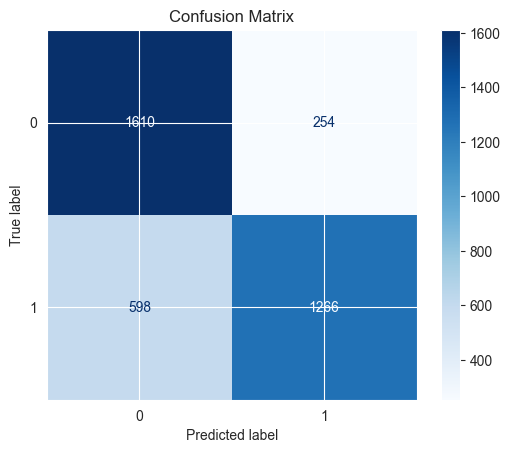

Recall:  0.6791845493562232
F1-score:  0.74822695035461
Classification metrics:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1864
           1       0.83      0.68      0.75      1864

    accuracy                           0.77      3728
   macro avg       0.78      0.77      0.77      3728
weighted avg       0.78      0.77      0.77      3728



In [16]:
months = ['graph_2015-01-31', 'graph_2015-02-28', 'graph_2015-03-31', 'graph_2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 16)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])

X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.3, random_state=42)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(8, 16, 3)),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

## Average performance on newer month groups

In [17]:
graph_model_data = utils.create_train_test_objects('israel_palestine', num_walks=5, walk_length=5, dimensions=16)

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-07-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-08-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2023-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-09-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-10-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-11-30


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2024-12-31


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Processing graph for date: 2025-01-31


In [27]:
target_graphs = []
target_graphs.append(graph_model_data['2023-11-30']['graph'])
target_graphs.append(graph_model_data['2025-01-31']['graph'])

nv_models = []
keys = list(graph_model_data.keys())[:4]
models_list = []
for key in keys:
    models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(models_list)

keys = list(graph_model_data.keys())[5:9]
models_list = []
for key in keys:
    models_list.append(graph_model_data[key]['word2vec'])
nv_models.append(models_list)

utils.summary_evaluation_for_month_groups_ex_6(
    model=model,
    target_graphs=target_graphs,
    nv_models=nv_models
)

True
(8, 16, 3)
(3128, 8, 16, 3)
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8127 - loss: 0.4405
Test Accuracy: 72.28%
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
True
(8, 16, 3)
(2780, 8, 16, 3)
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.5134
Test Accuracy: 70.65%
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


{'mean_acc': 0.7146504535502033,
 'mean_prec': 0.7624644866581249,
 'mean_rec': 0.6273698688108337,
 'mean_f1': 0.687284274357405,
 'all_metrics': [[0.7228260869565217, 0.7064748201438849],
  [0.7931034482758621, 0.7318255250403877],
  [0.6029411764705882, 0.6517985611510791],
  [0.6850708318198329, 0.6894977168949772]]}

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 61.74it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 83.33it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 63.11it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 83.33it/s]


True
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6685 - loss: 0.5951
Test Accuracy: 75.81%
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


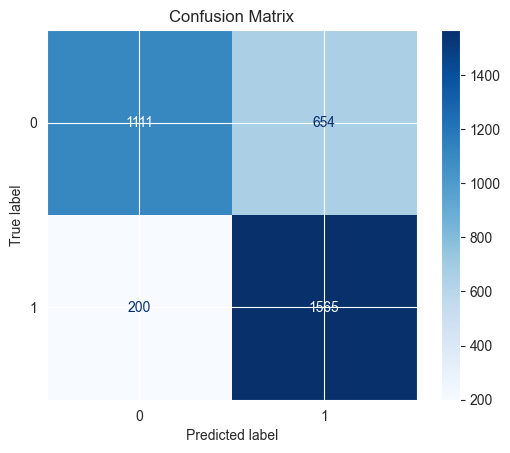

Recall:  0.886685552407932
F1-score:  0.7856425702811245
Classification metrics:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      1765
           1       0.71      0.89      0.79      1765

    accuracy                           0.76      3530
   macro avg       0.78      0.76      0.75      3530
weighted avg       0.78      0.76      0.75      3530



In [262]:
months = ['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 16)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2018-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 102.87it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 30.87it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 72.26it/s]


True
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6764 - loss: 0.6229
Test Accuracy: 76.22%
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


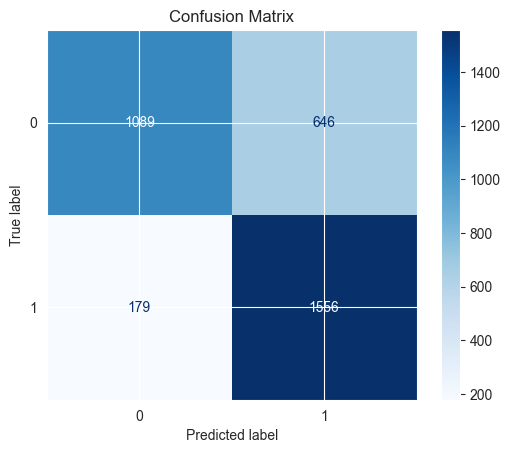

Recall:  0.8968299711815562
F1-score:  0.7904495808991618
Classification metrics:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73      1735
           1       0.71      0.90      0.79      1735

    accuracy                           0.76      3470
   macro avg       0.78      0.76      0.76      3470
weighted avg       0.78      0.76      0.76      3470



In [263]:
months = ['2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 16)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2015-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

## Optimization 2

In [269]:
months = ['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 204.35it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 69.87it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 33.93it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 53.58it/s]


True
Epoch 1/20


C:\Users\User\Desktop\xai-graphs\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6042 - loss: 16.3243 - val_accuracy: 0.7498 - val_loss: 0.5406
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7339 - loss: 0.5325 - val_accuracy: 0.7346 - val_loss: 0.5189
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7379 - loss: 0.5083 - val_accuracy: 0.7015 - val_loss: 0.6164
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7685 - loss: 0.4791 - val_accuracy: 0.7721 - val_loss: 0.4645
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7768 - loss: 0.4738 - val_accuracy: 0.6953 - val_loss: 0.7273
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7478 - loss: 0.5616 - val_accuracy: 0.7301 - val_loss: 0.5324
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7348 - loss: 0.5066 - val_accuracy: 0.7766 - val_loss: 0.4789
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7782 - loss: 0.4689 - val_accuracy: 0.77

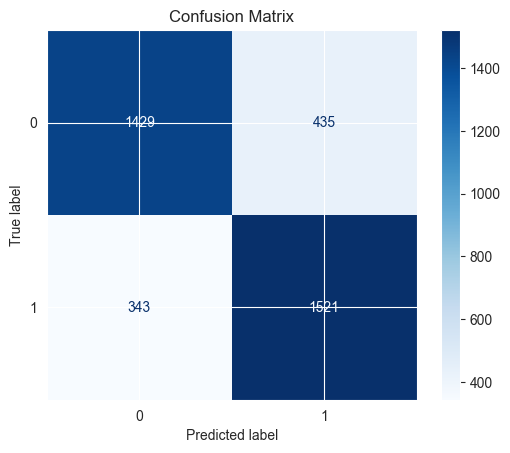

Recall:  0.8159871244635193
F1-score:  0.7963350785340314
Classification metrics:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1864
           1       0.78      0.82      0.80      1864

    accuracy                           0.79      3728
   macro avg       0.79      0.79      0.79      3728
weighted avg       0.79      0.79      0.79      3728



In [271]:
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])

X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.3, random_state=42)
model = models.Sequential([
    layers.Conv2D(32, (6, 2), padding='same', activation='relu', input_shape=(8, 20, 3)),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 37.31it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 35.65it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 32.00it/s]


True
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7761 - loss: 0.4732
Test Accuracy: 79.60%
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


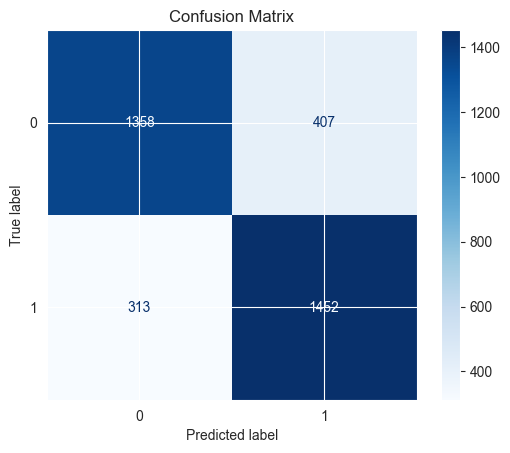

Recall:  0.8226628895184136
F1-score:  0.8013245033112583
Classification metrics:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1765
           1       0.78      0.82      0.80      1765

    accuracy                           0.80      3530
   macro avg       0.80      0.80      0.80      3530
weighted avg       0.80      0.80      0.80      3530



In [272]:
months = ['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2018-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 53.19it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 49.82it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 35.36it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 44.23it/s]


True
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6623 - loss: 0.6464
Test Accuracy: 76.17%
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


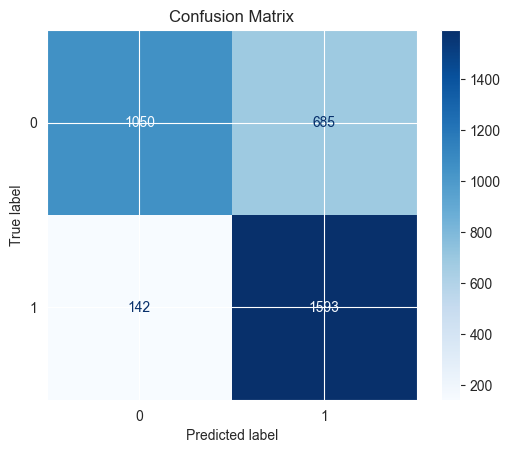

Recall:  0.9181556195965418
F1-score:  0.7939197607774732
Classification metrics:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72      1735
           1       0.70      0.92      0.79      1735

    accuracy                           0.76      3470
   macro avg       0.79      0.76      0.76      3470
weighted avg       0.79      0.76      0.76      3470



In [273]:
months = ['2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2015-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

## Optimization 3

In [274]:
months = ['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 184.25it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 36.77it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 40.33it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 33.04it/s]


True


C:\Users\User\Desktop\xai-graphs\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5933 - loss: 1.4072 - val_accuracy: 0.7614 - val_loss: 0.5129
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7312 - loss: 0.5227 - val_accuracy: 0.6434 - val_loss: 0.7125
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7016 - loss: 0.5786 - val_accuracy: 0.7721 - val_loss: 0.4587
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7514 - loss: 0.4927 - val_accuracy: 0.7694 - val_loss: 0.4640
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7715 - loss: 0.4710 - val_accuracy: 0.7802 - val_loss: 0.4671
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7772 - loss: 0.4731 - val_accuracy: 0.7864 - val_loss: 0.4571
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7722 - loss: 0.4778 - val_accuracy: 0.7739 - val_loss: 0.4876
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7639 - loss: 0.4822 - val_accu

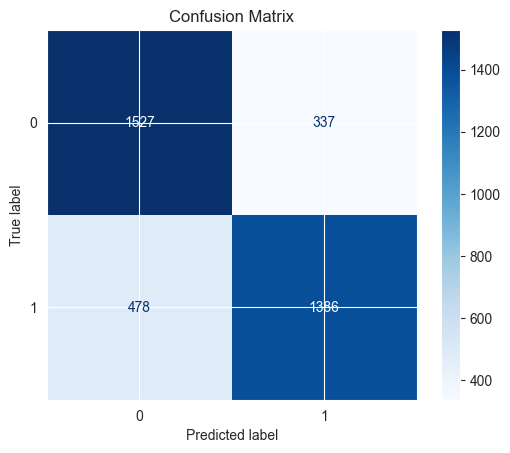

Recall:  0.7435622317596566
F1-score:  0.7727906328408141
Classification metrics:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1864
           1       0.80      0.74      0.77      1864

    accuracy                           0.78      3728
   macro avg       0.78      0.78      0.78      3728
weighted avg       0.78      0.78      0.78      3728



In [280]:
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2015-05-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])

X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.3, random_state=42)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(8, 20, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (6, 15), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 78.72it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 34.72it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


True
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8083 - loss: 0.4287
Test Accuracy: 78.67%
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


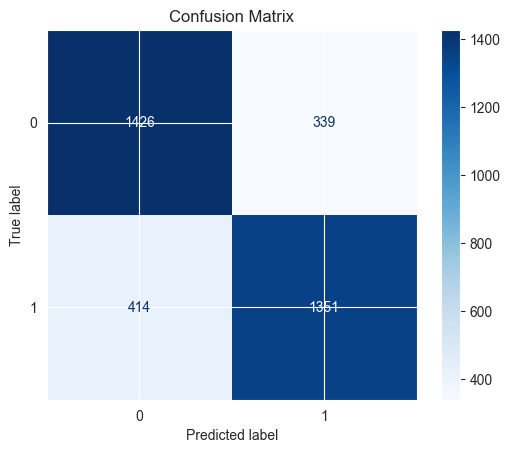

Recall:  0.7654390934844193
F1-score:  0.78205499276411
Classification metrics:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1765
           1       0.80      0.77      0.78      1765

    accuracy                           0.79      3530
   macro avg       0.79      0.79      0.79      3530
weighted avg       0.79      0.79      0.79      3530



In [281]:
months = ['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2018-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))

Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 38.46it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 38.46it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 44.45it/s]


Computing transition probabilities:   0%|          | 0/222 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


True
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7866 - loss: 0.4521
Test Accuracy: 78.24%
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


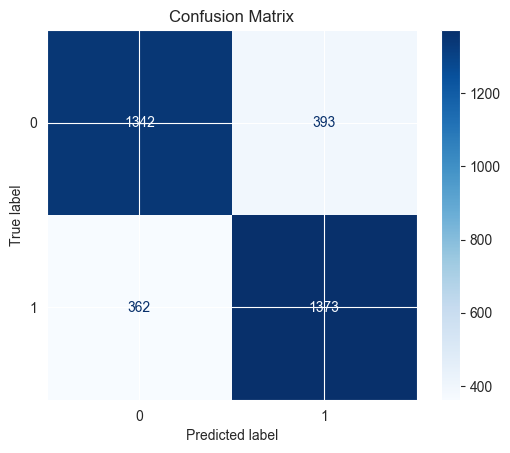

Recall:  0.7913544668587896
F1-score:  0.7843473293344758
Classification metrics:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1735
           1       0.78      0.79      0.78      1735

    accuracy                           0.78      3470
   macro avg       0.78      0.78      0.78      3470
weighted avg       0.78      0.78      0.78      3470



In [282]:
months = ['2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']
graphs = load_graphs(months)
j_nv, f_nv, m_nv, a_nv, j_model, f_model, m_model, a_model = create_nv_models(graphs, 5, 5, 20)
n_vecs = [j_nv, f_nv, m_nv, a_nv]
nv_models = [j_model, f_model, m_model, a_model]
images = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            key = f'{n_sorted[0]}-{n_sorted[1]}'
            ds = pd.DataFrame()
            vectors = []
            for i in range(len(nv_models)):
                vectors.append(nv_models[i].wv[node1])
                vectors.append(nv_models[i].wv[node2])
            img = np.stack(tuple(vectors), axis=0)
            normalized_img = (img + 1) / 2
            scaled_img = (normalized_img * 255).astype(np.uint8)
            rgb_img = None
            if scaled_img.ndim == 2:
                rgb_img = np.stack([scaled_img] * 3, axis=-1)
            else:
                rgb_img = scaled_img
            '''if scaled_img.ndim == 2:  # If the image is 2D (grayscale)
                rgb_img = np.stack([scaled_img] * 3, axis=-1)  # Convert to RGB by duplicating the grayscale data
            elif scaled_img.shape[-1] != 3:  # If the last dimension is not 3 (not already RGB)
                rgb_img = np.stack([scaled_img[..., 0]] * 3, axis=-1)  # Expand the last dimension to 3 channels
            else:
                rgb_img = scaled_img'''
            images[key] = rgb_img
with open(f'../data/graphs/graph_2015-07-31.pkl', 'rb') as f:
    target_graph = pickle.load(f)
nodes = target_graph.nodes
ds_dict = dict()
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2:
            n_sorted = sorted([node1, node2])
            ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 0
for el in target_graph.edges(data=True):
    if el[2]['weight'] > 0:
        node1 = el[0]
        node2 = el[1]
        n_sorted = sorted([node1, node2])
        ds_dict[f'{n_sorted[0]}-{n_sorted[1]}'] = 1
all_images = []
all_labels = []
for key in ds_dict.keys():
    all_labels.append(ds_dict[key])
    all_images.append(images[key])

print(len(all_labels) == len(all_images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

data = pd.DataFrame({'img': list(all_images), 'target': all_labels})

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

balanced_data = pd.concat([majority_undersampled, minority_class])
balanced_images = np.array(balanced_data['img'].tolist())
balanced_labels = np.array(balanced_data['target'])
test_loss, test_acc = model.evaluate(balanced_images, balanced_labels)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred_probs = model.predict(balanced_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(balanced_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Recall: ', recall_score(balanced_labels, y_pred))
print('F1-score: ', f1_score(balanced_labels, y_pred))
print("Classification metrics:")
print(classification_report(balanced_labels, y_pred))